# RCP 216 - Projet - Automated Essay Scoring
Benoît Mayer

Vous trouverez ci-dessous tout le code que j'ai utilisé pour le projet de RCP 216 - Fouille des données massives.

Si besoin, toutes les données et l'historique des modifications sont disponibles sur ce dépôt Git: https://github.com/bemayer/Automated-Essay-Scoring



## Installation

In [1]:
import re
import kaggle
import zipfile
import pandas as pd
import numpy as np
import language_check
from os import remove, rename
from os.path import exists
from wordcloud import WordCloud
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Palatino'
from textgenrnn import textgenrnn
from statsmodels.stats.outliers_influence import variance_inflation_factor

from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import udf

from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler, Word2Vec

from sparknlp.base import DocumentAssembler, Finisher, EmbeddingsFinisher, \
    LightPipeline
from sparknlp.annotator import Tokenizer, Normalizer, StopWordsCleaner, \
    WordEmbeddingsModel, SentenceEmbeddings
from sparknlp.pretrained import LemmatizerModel

from sklearn.svm import LinearSVR
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge

from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential, load_model

# Télécharger les données
if not exists('Data'):
    kaggle.api.authenticate()
    kaggle.api.competition_download_files('asap-aes')
    zipfile.ZipFile('asap-aes.zip').extractall(path='Data')
    remove('asap-aes.zip')



# Créer la session Spark
sc = SparkSession.builder \
    .appName('Spark NLP')\
    .master('local[4]')\
    .config('spark.driver.memory','16G')\
    .config('spark.driver.maxResultSize', '0') \
    .config('spark.kryoserializer.buffer.max', '2000M')\
    .config('spark.jars.packages', 'com.johnsnowlabs.nlp:spark-nlp_2.12:3.0.0') \
    .getOrCreate()

# Importer les données
data = sc.read.csv('./Data/training_set_rel3.tsv', sep='\t',
    encoding='windows-1252', header=True, inferSchema=True)

Using TensorFlow backend.


## Analyses exploratoires

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12978 entries, 0 to 12977
Data columns (total 28 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   essay_id        12978 non-null  int32  
 1   essay_set       12978 non-null  int32  
 2   essay           12978 non-null  object 
 3   rater1_domain1  12976 non-null  float64
 4   rater2_domain1  12976 non-null  float64
 5   rater3_domain1  128 non-null    float64
 6   domain1_score   12976 non-null  float64
 7   rater1_domain2  1799 non-null   float64
 8   rater2_domain2  1799 non-null   float64
 9   domain2_score   1799 non-null   float64
 10  rater1_trait1   2292 non-null   float64
 11  rater1_trait2   2292 non-null   float64
 12  rater1_trait3   2292 non-null   float64
 13  rater1_trait4   2292 non-null   float64
 14  rater1_trait5   723 non-null    float64
 15  rater1_trait6   723 non-null    float64
 16  rater2_trait1   2292 non-null   float64
 17  rater2_trait2   2292 non-null  

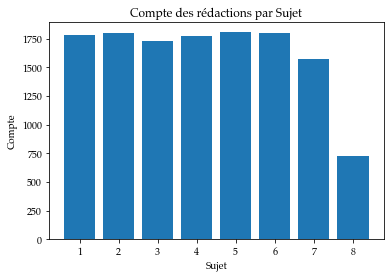

+-----+---+---+----+------+-------+---------+
|Sujet|Min|Max|  Nb|Unique|Moyenne|EcartType|
+-----+---+---+----+------+-------+---------+
|    1|  2| 12|1783|    11|   8.53|     1.54|
|    2|  1|  6|1799|     6|   3.42|     0.77|
|    3|  0|  3|1726|     4|   1.85|     0.82|
|    4|  0|  3|1771|     4|   1.43|     0.94|
|    5|  0|  4|1805|     5|   2.41|     0.97|
|    6|  0|  4|1800|     5|   2.72|     0.97|
|    7|  2| 24|1569|    23|  16.06|     4.59|
|    8| 10| 60| 723|    34|  36.95|     5.75|
+-----+---+---+----+------+-------+---------+



In [2]:
# Structure des données
data.createOrReplaceTempView('data')
data_pd = data.toPandas()
data_pd.info()

# Compte par sujet
query = '''SELECT essay_set as Sujet, COUNT(essay) as Compte FROM data GROUP BY essay_set
     ORDER BY essay_set'''
essay_nb = sc.sql(query).toPandas()
fig, ax = plt.subplots()
ax.bar(essay_nb['Sujet'], essay_nb['Compte'])
plt.title('Compte des rédactions par Sujet')
plt.xlabel('Sujet')
plt.ylabel('Compte')
plt.show()

# Distribution des score par sujet
query = '''SELECT essay_set as Sujet, min(domain1_score) as Min,
     max(domain1_score) as Max, count(domain1_score) as Nb,
     count(distinct domain1_score) as Unique,
     format_number(avg(domain1_score), '#.##') as Moyenne,
     format_number(stddev(domain1_score), '#.##') as EcartType
     FROM data GROUP BY essay_set ORDER BY Sujet'''
sc.sql(query).show()

## Normalisation du score et échantillonage

In [3]:
data = data.filter('domain1_score is not null')

scores_by_set = {}
assembler = (VectorAssembler().setInputCols(['domain1_score'])
    .setOutputCol('domain1_score_vector'))
scaler = (StandardScaler().setWithMean(True)
    .setInputCol('domain1_score_vector').setOutputCol('score_vector'))

for set in range(1,9):
    scores_by_set[set] = data.select('essay_id', 'essay_set',
        'domain1_score').filter('essay_set == ' + str(set))
    scores_by_set[set] = assembler.transform(scores_by_set[set])
    scores_by_set[set] = (scaler.fit(scores_by_set[set])
        .transform(scores_by_set[set]).toPandas().set_index('essay_id'))

for set in range(1,9):
    score = [[essay, scores_by_set[set]['score_vector'][essay][0]]
        for essay in scores_by_set[set].index]
    score = (pd.DataFrame(score, columns=['essay_id', 'score'])
        .set_index('essay_id'))
    scores_by_set[set] = pd.concat([scores_by_set[set], score], axis = 1)

scores = pd.concat(scores_by_set.values())[['essay_set', 'score']]
round(scores.score.std(), 3)
round(scores.score.mean(), 3)

rank_by_set = {}
for set in range(1,9):
    rank_by_set[set] = (scores.loc[scores['essay_set'] == set]['score']
        .rank(pct=True, method ='first'))

rank = pd.concat(rank_by_set.values())
rank = rank.rename('rank')

scores = pd.concat([scores, rank], axis=1)

scores.loc[scores['rank'] <= 1/5, 'rank_group'] = '0'
scores.loc[(scores['rank'] > 1/5) & (scores['rank'] <= 2/5), 'rank_group'] = '1'
scores.loc[(scores['rank'] > 2/5) & (scores['rank'] <= 3/5), 'rank_group'] = '2'
scores.loc[(scores['rank'] > 3/5) & (scores['rank'] <= 4/5), 'rank_group'] = '3'
scores.loc[scores['rank'] > 4/5, 'rank_group'] = '4'

table_count = pd.pivot_table(scores, values='score', index=['essay_set'],
    columns=['rank_group'], aggfunc=pd.Series.count, margins = True)
table_mean = pd.pivot_table(scores, values='score', index=['essay_set'],
    columns=['rank_group'], aggfunc=pd.Series.mean, margins = True)

print('\nComptes des rédactions par groupe:')
print(table_count)

print('\nNotes moyennes des rédactions par groupe:')
print(table_mean)

scores_train = scores.sample(frac=0.7, random_state=42)
scores_test = scores.loc[np.setdiff1d(scores.index, scores_train.index)]

table_count_train = (pd.pivot_table(scores_train, values='score',
    index=['essay_set'], columns=['rank_group'], aggfunc=pd.Series.count,
    margins = True))
table_mean_train = (pd.pivot_table(scores_train, values='score',
    index=['essay_set'], columns=['rank_group'], aggfunc=pd.Series.mean,
    margins = True))

print('\nComptes des rédactions par groupe pour l\'échantillon de test:')
print(table_count_train)

print('\nNotes moyennes des rédactions par groupe pour l\'échantillon de test:')
print(table_mean_train)


Comptes des rédactions par groupe:
rank_group       0       1       2       3       4      All
essay_set                                                  
1            356.0   357.0   356.0   357.0   357.0   1783.0
2            359.0   360.0   360.0   360.0   360.0   1799.0
3            345.0   345.0   345.0   345.0   346.0   1726.0
4            354.0   354.0   354.0   354.0   355.0   1771.0
5            361.0   361.0   361.0   361.0   361.0   1805.0
6            360.0   360.0   360.0   360.0   360.0   1800.0
7            313.0   314.0   314.0   314.0   314.0   1569.0
8            144.0   145.0   144.0   145.0   145.0    723.0
All         2592.0  2596.0  2594.0  2596.0  2598.0  12976.0

Notes moyennes des rédactions par groupe:
rank_group         0         1         2         3         4           All
essay_set                                                                 
1          -1.327450 -0.343387 -0.175421  0.515939  1.326109  4.022955e-15
2          -1.259479 -0.536730 -0.03

## Calcul de caractéristiques

In [4]:
def nb_words(str):
    return(len(str.split()))

def nb_organization(str):
    return(str.count('@ORGANIZATION'))

def nb_caps(str):
    return(str.count('@CAPS'))

def nb_person(str):
    return(str.count('@PERSON') + str.count('@DR'))

def nb_location(str):
    return(str.count('@LOCATION') + str.count('@CITY') + str.count('@STATE'))

def nb_money(str):
    return(str.count('@MONEY'))

def nb_time(str):
    return(str.count('@TIME'))

def nb_date(str):
    return(str.count('@DATE') + str.count('@MONTH'))

def nb_percent(str):
    return(str.count('@PERCENT') + str.count('@NUM'))

def Compute_Features(data):
    nb_wordsUdf = udf(lambda str: nb_words(str), IntegerType())
    nb_organizationUdf = udf(lambda str: nb_organization(str), IntegerType())
    nb_capsUdf = udf(lambda str: nb_caps(str), IntegerType())
    nb_personUdf = udf(lambda str: nb_person(str), IntegerType())
    nb_locationUdf = udf(lambda str: nb_location(str), IntegerType())
    nb_moneyUdf = udf(lambda str: nb_money(str), IntegerType())
    nb_timeUdf = udf(lambda str: nb_time(str), IntegerType())
    nb_dateUdf = udf(lambda str: nb_date(str), IntegerType())
    nb_percentUdf = udf(lambda str: nb_percent(str), IntegerType())
    data = data.withColumn('nb_words', nb_wordsUdf(data.essay))
    data = data.withColumn('nb_organization', nb_organizationUdf(data.essay))
    data = data.withColumn('nb_caps', nb_capsUdf(data.essay))
    data = data.withColumn('nb_person', nb_personUdf(data.essay))
    data = data.withColumn('nb_location', nb_locationUdf(data.essay))
    data = data.withColumn('nb_money', nb_moneyUdf(data.essay))
    data = data.withColumn('nb_time', nb_timeUdf(data.essay))
    data = data.withColumn('nb_date', nb_dateUdf(data.essay))
    data = data.withColumn('nb_percent', nb_percentUdf(data.essay))
    return data

data = Compute_Features(data)

## Correction grammaticale

In [5]:
def nb_error(str):
    matches = language_check.LanguageTool('en-US').check(str)
    nb_error = (len(matches))
    return(nb_error)

def correcter(str):
    corrected = language_check.LanguageTool('en-US').correct(str)
    return(corrected)

# Remplacement par des espaces des char qui gènent la tokenisation de Spark
def replace_char(str):
    for char in ['\\', '/', '(', ')', '[', ']', '{', '}']:
        str = str.replace(char, ' ')
    return (str)

def replace_anom(str):
    for char in ['@ORGANIZATION.', '@CAPS.', '@PERSON.', '@LOCATION.',
        '@MONEY.', '@TIME.', '@DATE.', '@PERCENT.', '@MONTH.', '@NUM.',
        '@DR.', '@CITY.', '@STATE.']:
        str = re.sub(char, ' ', str)
    return (str)

def Correct_Essay(data):
    nb_errorUdf = udf(lambda str: nb_error(str), IntegerType())
    correcterUdf = udf(lambda str: correcter(str), StringType())
    replace_charUdf = udf(lambda str: replace_char(str), StringType())
    replace_anomUdf = udf(lambda str: replace_anom(str), StringType())
    data = data.withColumn('nb_orth_error', nb_errorUdf(data.essay))
    data = data.withColumn('essay', correcterUdf(data.essay))
    data = data.withColumn('essay', replace_charUdf(data.essay))
    data = data.withColumn('essay', replace_anomUdf(data.essay))
    return data

data = Correct_Essay(data)

if not exists('Data/data_corrected.parquet'):
    data.write.parquet('Data/data_corrected.parquet')

data = sc.read.parquet('Data/data_corrected.parquet')

## Visualisation des données

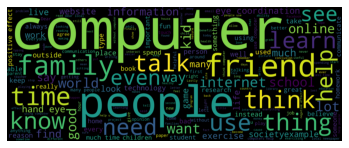

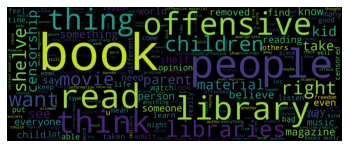

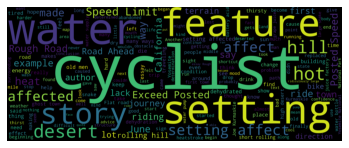

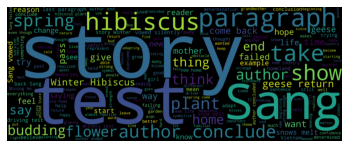

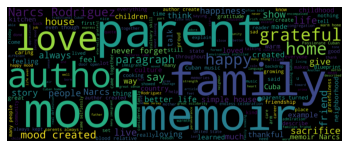

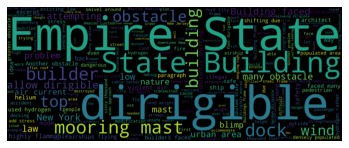

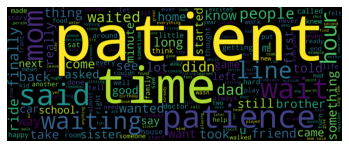

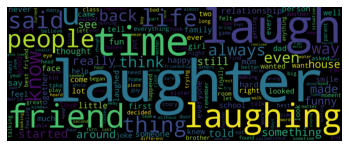

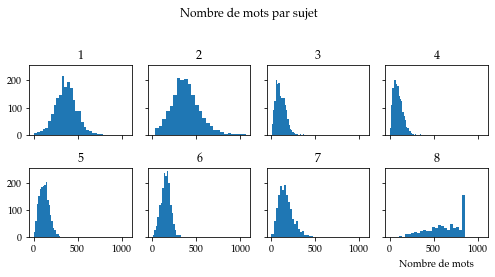

In [6]:
data_pd = data.toPandas()

# Nuages de mots
stopwords = StopWordsCleaner().getStopWords() + ['one', 'day', 'make',  'like',
    'went', 'go', 'going', 'also', 'get', 'got']
for set in range(1, 9):
    text = ' '.join([essay for essay in
        data_pd[data_pd.essay_set == set].essay])
    wordcloud = WordCloud(width = 5000, height = 2000,
        background_color='black', stopwords=stopwords).generate(text)
    # plt.figure(figsize=(50,20))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    # plt.title('Sujet ' + str(set), fontsize=120)
    plt.savefig('Data/set_' + str(set) + '.png', format='png',
        bbox_inches = 'tight', pad_inches = 0)
    plt.show()

# Distribution du nombre de mots par rédaction
(data_pd.hist(column='nb_words', by='essay_set', bins=25, sharey=True,
    sharex=True, layout=(2, 4), figsize=(7,4), rot=0))
plt.suptitle('Nombre de mots par sujet')
plt.xlabel('Nombre de mots')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Pipeline de prétraitements et vectorisation

In [7]:
documenter = (DocumentAssembler().setCleanupMode('shrink').setInputCol('essay')
                .setOutputCol('document'))
tokenizer = Tokenizer().setInputCols(['document']).setOutputCol('tokenized')
normalizer = (Normalizer().setLowercase(True).setInputCols(['tokenized'])
                .setOutputCol('normalized'))
lemmatizer = (LemmatizerModel.pretrained(name = 'lemma_antbnc', lang='en')
                .setInputCols(['normalized']).setOutputCol('lemmatized'))
cleaner = (StopWordsCleaner().setCaseSensitive(False)
                .setInputCols(['lemmatized']).setOutputCol('cleaned'))
finisher = Finisher().setInputCols(['cleaned']).setOutputCols('finished')
vectorizer = (Word2Vec().setSeed(42).setVectorSize(300)
                .setInputCol('finished').setOutputCol('vectorized'))
vectorizer2 = (WordEmbeddingsModel.pretrained('glove_6B_300', 'xx')
                .setInputCols('document', 'lemmatized')
                .setOutputCol('embedded'))
averager = (SentenceEmbeddings().setPoolingStrategy('SUM')
    .setInputCols(['document', 'embedded']).setOutputCol('averaged'))
finisher2 = (EmbeddingsFinisher().setInputCols(['averaged'])
    .setOutputCols('vectorized'))

lemma_antbnc download started this may take some time.
Approximate size to download 907,6 KB
[OK!]
glove_6B_300 download started this may take some time.
Approximate size to download 426,2 MB
[OK!]


In [8]:

data_t = Pipeline().setStages([documenter, tokenizer, normalizer,
                lemmatizer, cleaner, finisher]).fit(data).transform(data)

w2v_model = (Word2Vec().setSeed(42).setVectorSize(300)
                .setInputCol('finished').setOutputCol('vectorized')).fit(data_t)

w2v_model.findSynonyms('bike', 5).toPandas()

,word,similarity
0,mountain,0.679528
1,ride,0.678682
2,tire,0.658973
3,wood,0.643557
4,trail,0.640353


In [9]:
pipeline_w2v = Pipeline().setStages([documenter, tokenizer, normalizer,
                lemmatizer, cleaner, finisher, vectorizer]).fit(data)
pipeline_glove = (Pipeline().setStages([documenter, tokenizer, normalizer,
                lemmatizer,  cleaner, vectorizer2, averager, finisher2])
                .fit(data))

pipeline_w2v_light = LightPipeline(pipeline_w2v)
pipeline_glove_light = LightPipeline(pipeline_glove)



In [10]:
if not exists('Data/data_w2v.parquet'):
    data_w2v = pipeline_w2v_light.transform(data)
    data_w2v = data_w2v.drop('finished')
    data_w2v.write.parquet('Data/data_w2v.parquet')

data_w2v_pd = pd.read_parquet('Data/data_w2v.parquet')

if not exists('Data/data_glove.parquet'):
    data_glove = pipeline_glove_light.transform(data)
    data_glove = data_glove.drop('document', 'tokenized', 'normalized',
        'cleaned', 'lemmatized', 'embedded', 'averaged')
    data_glove.write.parquet('Data/data_glove.parquet')

data_glove_pd = pd.read_parquet('Data/data_glove.parquet')

## Création et enregistrement des données d'entraînement et de test

In [11]:
if data_w2v_pd.index.name != 'essay_id':
    data_w2v_pd = data_w2v_pd.set_index('essay_id')
if data_glove_pd.index.name != 'essay_id':
    data_glove_pd = data_glove_pd.set_index('essay_id')

selected = ['essay_set'] + [s for s in data.columns if 'nb' in s]
vec_names = ['vec_' + str(i) for i in range(0, 300)]

vector_w2v = [[essay, *(data_w2v_pd['vectorized'][essay]['values'])]
    for essay in data_w2v_pd['vectorized'].index]
vector_w2v = (pd.DataFrame(vector_w2v, columns=['essay_id', *vec_names])
    .set_index('essay_id'))

vector_glove = [[essay, *(data_glove_pd['vectorized'][essay][0])]
    for essay in data_glove_pd['vectorized'].index]
vector_glove = (pd.DataFrame(vector_glove, columns=['essay_id', *vec_names])
    .set_index('essay_id'))

X_w2v = pd.concat([data_w2v_pd[selected], vector_w2v], axis = 1)
X_glove = pd.concat([data_glove_pd[selected], vector_glove], axis = 1)

X_w2v_train = X_w2v.loc[X_w2v.index.intersection(scores_train.index)]
X_w2v_test = X_w2v.loc[X_w2v.index.intersection(scores_test.index)]

X_glove_train = X_glove.loc[X_glove.index.intersection(scores_train.index)]
X_glove_test = X_glove.loc[X_glove.index.intersection(scores_test.index)]

if not exists('Data/X_w2v_train.taz'):
    X_w2v_train.to_csv('Data/X_w2v_train.taz', compression='gzip')
if not exists('Data/X_w2v_test.taz'):
    X_w2v_test.to_csv('Data/X_w2v_test.taz', compression='gzip')
if not exists('Data/X_glove_train.taz'):
    X_glove_train.to_csv('Data/X_glove_train.taz', compression='gzip')
if not exists('Data/X_glove_test.taz'):
    X_glove_test.to_csv('Data/X_glove_test.taz', compression='gzip')
if not exists('Data/y_train.taz'):
    scores_train.to_csv('Data/y_train.taz', compression='gzip')
if not exists('Data/y_test.taz'):
    scores_test.to_csv('Data/y_test.taz', compression='gzip')

## Vérification de la multicollinéarité

In [12]:
w2v_corr = X_w2v.corr()
w2v_corr_percent = ((w2v_corr.ge(0.7).sum().sum() 
    + w2v_corr.le(-0.7).sum().sum() - len(w2v_corr)) 
    / (w2v_corr.size - len(w2v_corr)))
print('Pourcentage de caractéristiques corrélées pour Word2Vec: '
    +'{:.2%}'.format(w2v_corr_percent))

glove_corr = X_glove.corr()
glove_corr_percent = ((glove_corr.ge(0.7).sum().sum() 
    + glove_corr.le(-0.7).sum().sum() - len(glove_corr)) 
    / (w2v_corr.size - len(w2v_corr)))
print('Pourcentage de caractéristiques corrélées pour GloVe: '
    +'{:.2%}'.format(glove_corr_percent))





Pourcentage de caractéristiques corrélées pour Word2Vec: 4.42%
Pourcentage de caractéristiques corrélées pour GloVe: 9.37%


In [13]:
if not exists('Data/vif_w2v.csv'):
    vif_w2v = pd.DataFrame()
    vif_w2v['VIF'] = [variance_inflation_factor(X_w2v.values, i) 
        for i in range(X_w2v.shape[1])]
    vif_w2v['variable'] = X_w2v.columns
    vif_w2v.to_csv('Data/vif_w2v.csv', index = False)
else:
    vif_w2v = pd.read_csv('Data/vif_w2v.csv')

if not exists('Data/vif_glove.csv'):
    vif_glove = pd.DataFrame()
    vif_glove['VIF'] = [variance_inflation_factor(X_glove.values, i) 
        for i in range(X_glove.shape[1])]
    vif_glove['variable'] = X_glove.columns
    vif_glove.to_csv('Data/vif_glove.csv', index = False)
else:
    vif_glove = pd.read_csv('Data/vif_glove.csv')

w2v_vif_percent = vif_w2v['VIF'].ge(5).sum() / vif_w2v['VIF'].count()
print('Pourcentage de score VIF supérieur à 5 pour Word2Vec: '
    +'{:.2%}'.format(w2v_vif_percent))

glove_vif_percent = vif_glove['VIF'].ge(5).sum() / vif_glove['VIF'].count()
print('Pourcentage de score VIF supérieur à 5 pour GloVe: '
    +'{:.2%}'.format(glove_vif_percent))

Pourcentage de score VIF supérieur à 5 pour Word2Vec: 97.11%
Pourcentage de score VIF supérieur à 5 pour GloVe: 97.11%


## Modélisation

J'ai utilisé les librairies *sklearn* et *tensorflow* pour les modélisations car il n'y a pas de SVR ni de réseaux de neurones parmi les modèles disponibles sur *pyspark*.  

### Chargement des données pour modélisation

In [14]:
def Score(model, train_error, test_error):
    return pd.Series((model, train_error, test_error), index = ('Model',
        'Train_error', 'Test_error'), name = model)

def Load_X(vec):
    names = {sample: 'X_' + vec + '_' + sample for sample in ['train', 'test']}
    data = {}
    for key, obj in names.items():
        if obj in globals():
            data[key] = globals()[obj]
        else:
            data[key] = (pd.read_csv('Data/' + obj + '.taz', compression='gzip')
                .set_index('essay_id'))
    return(data)

def Load_y():
    names = {sample: 'y_' + sample for sample in ['train', 'test']}
    data = {}
    for key, obj in names.items():
        if obj in globals():
            data[key] = globals()[obj]['score']
        else:
            data[key] = (pd.read_csv('Data/' + obj + '.taz', compression='gzip')
                .set_index('essay_id')['score'])
    return(data)

if not 'score_log' in globals():
    if not exists('Data/score_log.csv'):
        score_log = pd.DataFrame(columns=('Model', 'Train_error', 'Test_error'))
    else:
        score_log = pd.read_csv('Data/score_log.csv')

### Régression Linéaire

In [15]:
for vec in ['w2v', 'glove']:
    X = Load_X(vec)
    y = Load_y()
    model_name = 'LR_' + vec
    if model_name not in score_log['Model'].values:
        model = Ridge().fit(X['train'], y['train'])
        y_pred_train = pd.Series(model.predict(X['train']),
            index=X['train'].index)
        y_pred_test = pd.Series(model.predict(X['test']), index=X['test'].index)
        mse_train = mean_squared_error(y['train'], y_pred_train)
        mse_test = mean_squared_error(y['test'], y_pred_test)
        score_log = score_log.append(Score(model_name, mse_train, mse_test))

score_log.to_csv('Data/score_log.csv', index=False)

### Régression Linéaire par Sujet

In [16]:
for vec in ['w2v', 'glove']:
    for set in range(1, 9):
        X = Load_X(vec)
        X = {sample: X[sample][X[sample]['essay_set'] == set]
            for sample in ['test', 'train']}
        y = Load_y()
        y = {sample: y[sample][y[sample].index.intersection(X[sample].index)] for sample in ['test', 'train']}
        model_name = 'LR_' + vec + '_' + str(set)
        if model_name not in score_log['Model'].values:
            model = Ridge().fit(X['train'], y['train'])
            y_pred_train = pd.Series(model.predict(X['train']), index=X['train']
                .index)
            y_pred_test = pd.Series(model.predict(X['test']), index=X['test']
                .index)
            mse_train = mean_squared_error(y['train'], y_pred_train)
            mse_test = mean_squared_error(y['test'], y_pred_test)
            score_log = score_log.append(Score(model_name, mse_train, mse_test))

score_log.to_csv('Data/score_log.csv', index=False)

### SVR

In [17]:
def SVR(X, y, C):
    model = LinearSVR(C=C, max_iter=100000)
    model.fit(X['train'], y['train'])
    y_pred_train = pd.Series(model.predict(X['train']), index=X['train'].index)
    y_pred_test = pd.Series(model.predict(X['test']), index=X['test'].index)
    mse_train = mean_squared_error(y['train'], y_pred_train)
    mse_test = mean_squared_error(y['test'], y_pred_test)
    return mse_train, mse_test

In [18]:
for vec in ['w2v', 'glove']:
    X = Load_X(vec)
    y = Load_y()
    for C in [ 10 ** x for x in range(-5, 5)]:
        model_name = 'SVM_' + vec + '_' + str(C)
        if model_name not in score_log['Model'].values:
            score_log = score_log.append(Score(model_name, *(SVR(X, y, C))))

score_log.to_csv('Data/score_log.csv', index=False)

### Réseaux de neurones à deux couches

In [19]:
def NN_2(layer_1, layer_2):
    model = Sequential()
    model.add(Dense(layer_1))
    model.add(Dense(layer_2))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mean_squared_error', optimizer='rmsprop',
        metrics=['mae'])
    return model

def train_NN(model_name, X, y, layer_1, layer_2):
    model = NN_2(layer_1, layer_2)
    history = model.fit(X['train'], y['train'], epochs=50,
                        batch_size=128, validation_data=(X['test'], y['test']))
    epo = np.array(history.epoch)
    acc_train = np.array(history.history['mae'])
    acc_test = np.array(history.history['val_mae'])
    log = np.c_[epo, acc_train, acc_test]
    np.savetxt('./Data/' + model_name + '.csv', log, delimiter=',')
    loss_train, mse_train = model.evaluate(X['test'], y['test'])
    loss_test, mse_test = model.evaluate(X['train'], y['train'])
    return mse_train, mse_test

for vec in ['w2v', 'glove']:
    X = Load_X(vec)
    y = Load_y()
    for layer_1 in [10, 25, 50, 100, 200, 300]:
        for layer_2 in [10, 25, 50, 100, 200, 300]:
            model_name = 'NN_' + vec + '_' + str(layer_1) + '_' + str(layer_2)
            if model_name not in score_log['Model'].values:
                score_log = score_log.append(Score(model_name,
                    *(train_NN(model_name, X, y, layer_1, layer_2))))

score_log.to_csv('Data/score_log.csv', index=False)

In [20]:
print(score_log)

              Model  Train_error  Test_error
0     SVM_w2v_1e-05     0.924357    0.929910
1    SVM_w2v_0.0001     0.886393    0.893360
2     SVM_w2v_0.001     0.801276    0.809883
3      SVM_w2v_0.01     0.701937    0.707439
4       SVM_w2v_0.1     0.629144    0.634489
..              ...          ...         ...
106      LR_glove_6     0.213291    0.422556
107      LR_glove_7     0.312466    0.604133
108      LR_glove_8     0.172947    1.352896
109          LR_w2v     0.591933    0.602502
110        LR_glove     0.499741    0.572560

[111 rows x 3 columns]


## Génération automatique d'une rédaction

In [21]:
if not exists('Data/data_generated_glove.parquet'):
    if not exists('Data/essay_generated.txt'):
        if not exists('Data/textgenrnn_weights.hdf5'):
            data = sc.read.csv('./Data/training_set_rel3.tsv', sep='\t',
                encoding='windows-1252', header=True, inferSchema=True)
            good_essays = (data.filter(data.essay_set == 1)
                .filter(data.domain1_score > 10).select('essay').toPandas())
            textgen = textgenrnn()
            textgen.train_on_texts(good_essays.squeeze().to_list(),
                num_epochs=2,  gen_epochs=2)
            rename('textgenrnn_weights.hdf5', 
                'Data/textgenrnn_weights.hdf5')
        else:
            textgen = textgenrnn('Data/textgenrnn_weights.hdf5')
        essay_generated_list = textgen.generate(n=10, temperature=0.5,
            return_as_list=True)
        essay_generated = ' '.join(map(str, essay_generated_list))
        print(essay_generated,  file=open('Data/essay_generated.txt', 'w'))
    data_generated = sc.createDataFrame([{
        'essay_id':1,
        'essay_set':1,
        'essay':essay_generated,
    }])
    data_generated_glove = (pipeline_glove_light
        .transform(Correct_Essay(Compute_Features(data_generated))))
    data_generated_glove = data_generated_glove.drop('document', 'tokenized',
        'normalized', 'cleaned', 'lemmatized', 'embedded', 'averaged')
    data_generated_glove.write.parquet('Data/data_generated_glove.parquet')

file = open('Data/essay_generated.txt')
essay_generated = file.read()
file.close()

data_generated_glove_pd = pd.read_parquet('Data/data_generated_glove.parquet')

print(essay_generated)

D""" mosse you have a great computer that connects and face and the people and to play the computer in a computer that is agrees to see, and they can also be able to play out with the are of the pain and the world because they can convenient the society. They are one of the most interacting to the  Dear @CAPS1, @CAPS2 @CAPS3 @CAPS3 @CAPS1 for an internet and never don't have ever had a better are a great students and to access to all of the computer and instantly. The computer is better and prove the world and ever had to talk out the computer and technology is a week and the computer. The ho DDeNTH1 seem that the computer is the only because they're because they use the computer to socialize some others and is that and facebook in the reason about the powerposser to be and a positive effect on the video is really beneficial. As a lot of the internet and find the computer in the compute DDeNTH1 less the computer and main all the computer will be the easier and they are an exercise and 

In [22]:

X = Load_X('glove')
X = {sample: X[sample][X[sample]['essay_set'] == 1]
    for sample in ['test', 'train']}
y = Load_y()
y = {sample: y[sample][y[sample].index.intersection(X[sample].index)]
    .sort_index() for sample in ['test', 'train']}
model = Ridge().fit(X['train'], y['train'])
selected = ['essay_set'] + [s for s in data_generated_glove_pd.columns
    if 'nb' in s]
vec_names = ['vec_' + str(i) for i in range(0, 300)]
vector_generated_glove = [[essay,
    *(data_generated_glove_pd['vectorized'][essay][0])]
    for essay in data_generated_glove_pd['vectorized'].index]
vector_generated_glove = (pd.DataFrame(vector_generated_glove,
    columns=['essay_id', *vec_names]).set_index('essay_id'))
X_glove_generated = (pd.concat([data_generated_glove_pd[selected],
    vector_generated_glove], axis = 1))
print('Note obtenue: ' + str(model.predict(X_glove_generated)[0]))

Note obtenue: 0.9316600493226432
